# Projects VRE

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

In [3]:
# Directories where you saved the data
data_dir_energy = Path('./energy_france')
data_dir_climate = Path('./climate_france')

In [4]:
# Template filenames
filename_mask = 'mask_datagouv_french_regions_merra2_Nx_France.nc'
filename_climate = 'merra2_area_selection_output_{}_merra2_2010-2019.nc'
filename_energy = 'reseaux_energies_{}.csv'

In [5]:
def plot_grid_region_mask(da_mask):
    plt.scatter(da_mask['lon'], da_mask['lat'], c=da_mask, cmap='Set1')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Grid Point - Region Mask")
    plt.show()

In [6]:
def plot_climate_variable_mean(variable, da_climate, da_mask):
    da_climate_mean = da_climate.mean('time')
    plt.scatter(da_mask['lon'], da_mask['lat'], c=da_climate_mean, cmap='viridis')
    plt.title(f"Spatial Distribution of {variable}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [7]:
def plot_climate_variable_by_region(region_dfs):
    plt.figure(figsize=(12, 6))
    for region, df_region in region_dfs.items():
        plt.plot(df_region.index, df_region.mean(axis=1), label=region)
    plt.title("Climate Variable Trends (Original Data) by Region")
    plt.xlabel("Time")
    plt.ylabel("Mean Climate Variable Value")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

    monthly_climate_mean = {}
    for region, df_region in region_dfs.items():
        df_region['month'] = df_region.index.month
        monthly_mean = df_region.groupby('month').mean()
        monthly_climate_mean[region] = monthly_mean.mean(axis=1)

    df_climate_monthly = pd.DataFrame(monthly_climate_mean)

    for region in df_climate_monthly.columns:
        plt.plot(range(1, 13), df_climate_monthly[region], label=region)
    plt.title("Climate Variable Monthly Mean Trends by Region")
    plt.xlabel("Month")
    plt.ylabel("Mean Climate Variable Value")
    plt.xticks(range(1, 13))
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.show()

In [8]:
def plot_energy_time_series(df_energy):
    plt.figure(figsize=(12, 6))
    df_energy.plot(ax=plt.gca(), label="Original Data", alpha=0.7)
    plt.title("Energy Variable Trends (Original Data)")
    plt.xlabel("Time")
    plt.ylabel("Mean Energy Variable Value")
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()

    df_energy['month'] = df_energy.index.month
    df_energy_monthly_mean = df_energy.groupby('month').mean()

    df_energy_monthly_mean.plot(ax=plt.gca(), style='--', linewidth=2, label="Monthly Mean")
    plt.title("Energy Variable Monthly Mean Trends")
    plt.xlabel("Month")
    plt.ylabel("Mean Energy Variable Value")
    plt.xticks(range(1, 13))
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.show()

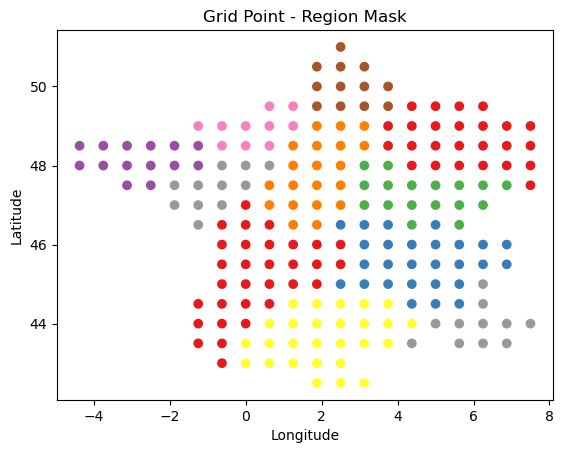

In [9]:
variables = [
    "height_500",
    "meridional_wind",
    "surface_density",
    "surface_downward_radiation",
    "surface_specific_humidity",
    "surface_temperature",
    "upper_meridional_wind",
    "upper_zonal_wind",
    "zonal_wind"
]

region_name_mapping = {
    'PACA': 'Provence-Alpes-Côte d\'Azur',
    'Ile-de-France': 'Île-de-France',
    'Hauts-de-France': 'Hauts-de-France',
    'Nouvelle-Aquitaine': 'Nouvelle-Aquitaine',
    'Bourgogne-Franche-Comté': 'Bourgogne-Franche-Comté',
    'Pays-de-la-Loire': 'Pays de la Loire',
    'Grand Est': 'Grand Est',
    'Normandie': 'Normandie',
    'Occitanie': 'Occitanie',
    'Centre-Val de Loire': 'Centre-Val de Loire',
    'Auvergne-Rhône-Alpes': 'Auvergne-Rhône-Alpes',
    'Bretagne': 'Bretagne'
}


region_dfs = {region: pd.DataFrame() for region in region_name_mapping.values()}

filepath_mask = Path(data_dir_climate, filename_mask)
ds_mask = xr.load_dataset(filepath_mask)
da_mask = ds_mask['mask']

plot_grid_region_mask(da_mask)

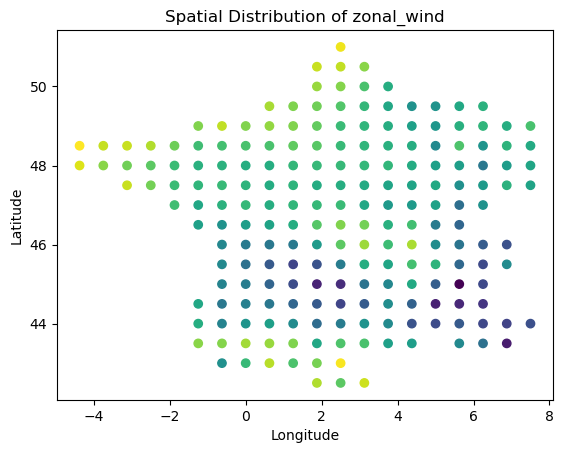

In [10]:
for variable in variables:
    filename = filename_climate.format(variable)
    filepath = Path(data_dir_climate, filename)

    da_climate = xr.load_dataset(filepath)[variable]
    da_climate_reg = da_climate.groupby(da_mask).mean().rename(mask='region')
    da_climate_reg['region'] = ds_mask['region'].values

    df_climate_reg = da_climate_reg.to_dataframe().reset_index()
    df_climate_reg = df_climate_reg.pivot(index='time', columns='region', values=variable)
    df_climate_mon = df_climate_reg.resample('MS').mean()

    for region in ds_mask['region'].values:
        region_fullname = region_name_mapping.get(region, region)
        if region_fullname in region_dfs:
            region_data = df_climate_mon[[region]].rename(columns={region: variable})
            region_dfs[region_fullname] = pd.concat([region_dfs[region_fullname], region_data], axis=1)

plot_climate_variable_mean(variable, da_climate, da_mask)

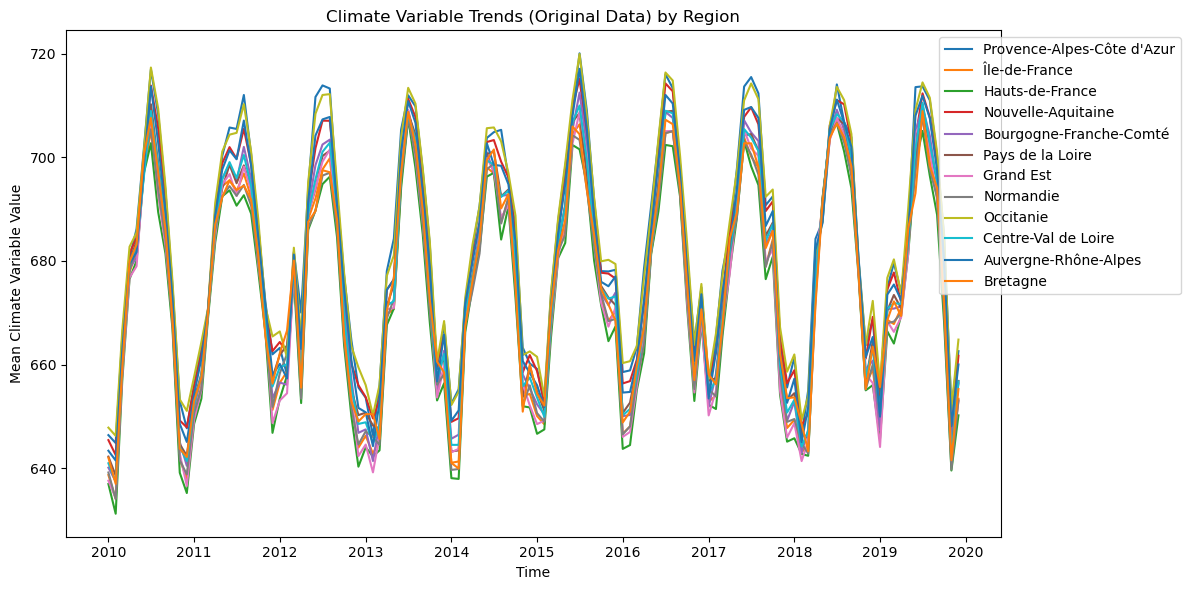

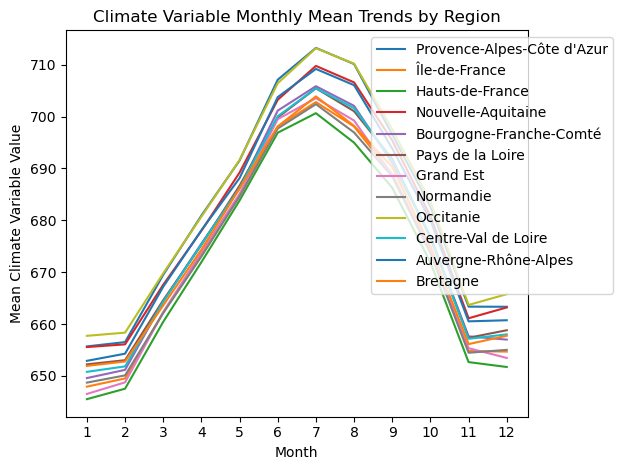

In [11]:
plot_climate_variable_by_region(region_dfs)

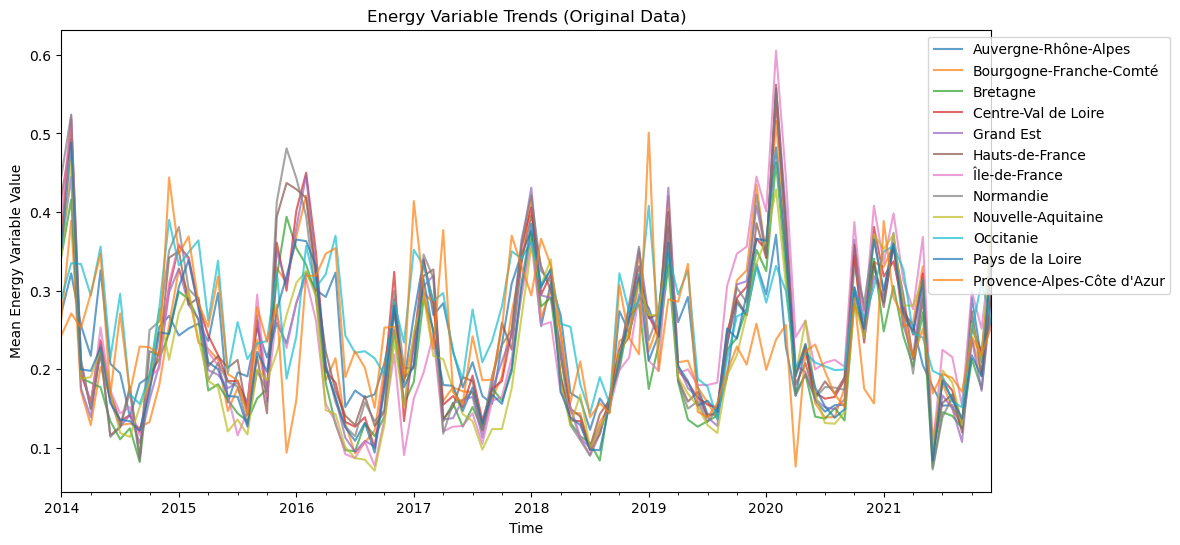

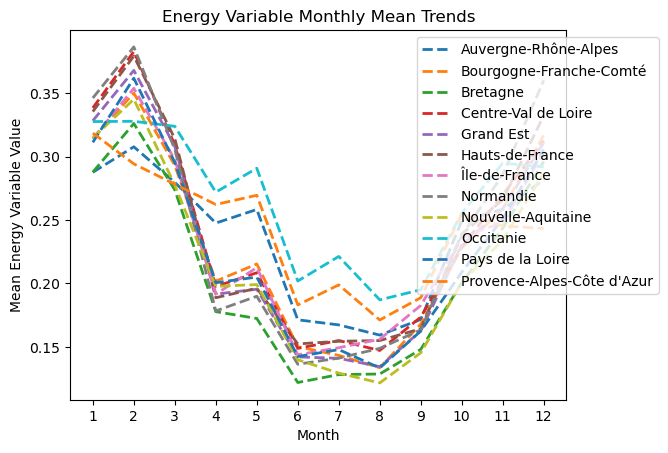

In [12]:
variable_name = 'capacityfactor_wind-onshore'
filename = filename_energy.format(variable_name)
filepath = Path(data_dir_energy, filename)
df_energy = pd.read_csv(filepath, index_col=0, header=0, parse_dates=True)
df_energy.index = df_energy.index + pd.offsets.MonthBegin(0)

plot_energy_time_series(df_energy)

In [13]:
merged_dfs = {}

for region, df_region in region_dfs.items():
    if region in df_energy.columns:
        df_region.index = pd.to_datetime(df_region.index)
        common_index = df_region.index.intersection(df_energy.index)
        df_region_trimmed = df_region.loc[common_index]
        df_energy_trimmed = df_energy.loc[common_index, [region]].rename(columns={region: 'ENERGY'})
        merged_dfs[region] = pd.concat([df_region_trimmed, df_energy_trimmed], axis=1)

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [15]:
def preprocess_data(merged_dfs, month=12):
    data_splits = {}

    for region, df_region in merged_dfs.items():
        X = df_region.drop(columns='ENERGY')
        y = df_region['ENERGY']
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=month, shuffle=False)
        data_splits[region] = (X_train, X_test, y_train, y_test, scaler, X.columns)

    return data_splits

In [16]:
def tune_models(X_train, y_train):
    svr_param_grid = {
        'kernel': ['linear', 'rbf'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1]
    }

    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_leaf': [1, 2, 4]
    }

    ridge_param_grid = {'alpha': [0.1, 1, 10]}
    lasso_param_grid = {'alpha': [0.1, 1, 10]}

    models = {}

    svr = SVR()
    svr_grid = GridSearchCV(svr, svr_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    svr_grid.fit(X_train, y_train)
    models['SVR'] = svr_grid.best_estimator_

    rf = RandomForestRegressor()
    rf_grid = GridSearchCV(rf, rf_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    models['RF'] = rf_grid.best_estimator_

    ridge = Ridge()
    ridge_grid = GridSearchCV(ridge, ridge_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    ridge_grid.fit(X_train, y_train)
    models['Ridge'] = ridge_grid.best_estimator_

    lasso = Lasso()
    lasso_grid = GridSearchCV(lasso, lasso_param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)
    lasso_grid.fit(X_train, y_train)
    models['Lasso'] = lasso_grid.best_estimator_

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    models['LR'] = lr
    
    return models

In [17]:
def train_and_evaluate(data_splits):
    results = {}
    predictions = {}

    for region, (X_train, X_test, y_train, y_test, scaler, feature_names) in data_splits.items():
        models = tune_models(X_train, y_train)

        region_results = {}
        region_predictions = {}

        for name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            region_results[name] = {'MSE': mse, 'R2': r2}
            region_predictions[name] = (y_test, y_pred)

        results[region] = region_results
        predictions[region] = region_predictions

    return results, predictions

In [18]:
def display_results(results, predictions):
    mse_results = {}
    r2_results = {}

    for region, region_results in results.items():
        for model_name, metrics in region_results.items():
            if model_name not in mse_results:
                mse_results[model_name] = []
                r2_results[model_name] = []
            
            mse_results[model_name].append(metrics['MSE'])
            r2_results[model_name].append(metrics['R2'])
    mse_df = pd.DataFrame(mse_results, index=results.keys())
    r2_df = pd.DataFrame(r2_results, index=results.keys())

    print("MSE Results:")
    print(mse_df.round(4))
    print("\nR2 Results:")
    print(r2_df.round(4))
    
    for region, region_predictions in predictions.items():
        plt.figure(figsize=(12, 6))
        for model_name, (y_test, y_pred) in region_predictions.items():
            plt.plot(y_test.index, y_pred, label=f"{model_name} Predictions", linestyle='--')
        plt.plot(y_test.index, y_test, label="True Values", color='black')
        plt.title(f"Prediction vs True Values for Region: {region}")
        plt.legend()
        plt.tight_layout()
        plt.show()

    region_names = ds_mask['region'].values
    region_indices = ds_mask['region_index'].values
    mask = ds_mask['mask'].values
    lat = ds_mask['lat'].values
    lon = ds_mask['lon'].values
    
    region_name_to_index = {region_name: region_index for region_name, region_index in zip(region_names, region_indices)}
    
    mse_map = np.full(mask.shape, np.nan)
    
    for region_name in np.unique(region_names):
        if region_name in region_name_mapping:
            mapped_region_name = region_name_mapping[region_name]
            if mapped_region_name in mse_df.index:
                region_index = region_name_to_index[region_name]
                mse_value = mse_df.loc[mapped_region_name, 'LR']
                mse_map[mask == region_index] = mse_value
    
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(lon, lat, c=mse_map, cmap='viridis', s=20, vmin=0, vmax=0.01)
    cbar = plt.colorbar(scatter, label='MSE')
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Spatial Distribution of MSE (LR Model)")
    plt.show()


MSE Results:
                               SVR      RF   Ridge   Lasso      LR
Provence-Alpes-Côte d'Azur  0.0041  0.0024  0.0026  0.0094  0.0023
Île-de-France               0.0044  0.0099  0.0088  0.0123  0.0072
Hauts-de-France             0.0031  0.0017  0.0016  0.0071  0.0014
Nouvelle-Aquitaine          0.0017  0.0029  0.0027  0.0060  0.0027
Bourgogne-Franche-Comté     0.0042  0.0048  0.0051  0.0103  0.0049
Pays de la Loire            0.0025  0.0034  0.0030  0.0054  0.0033
Grand Est                   0.0034  0.0036  0.0033  0.0099  0.0028
Normandie                   0.0030  0.0019  0.0020  0.0082  0.0024
Occitanie                   0.0039  0.0014  0.0012  0.0057  0.0011
Centre-Val de Loire         0.0024  0.0021  0.0023  0.0060  0.0026
Auvergne-Rhône-Alpes        0.0029  0.0007  0.0012  0.0044  0.0010
Bretagne                    0.0030  0.0022  0.0023  0.0056  0.0026

R2 Results:
                               SVR      RF   Ridge   Lasso      LR
Provence-Alpes-Côte d'Azur  0.5648  

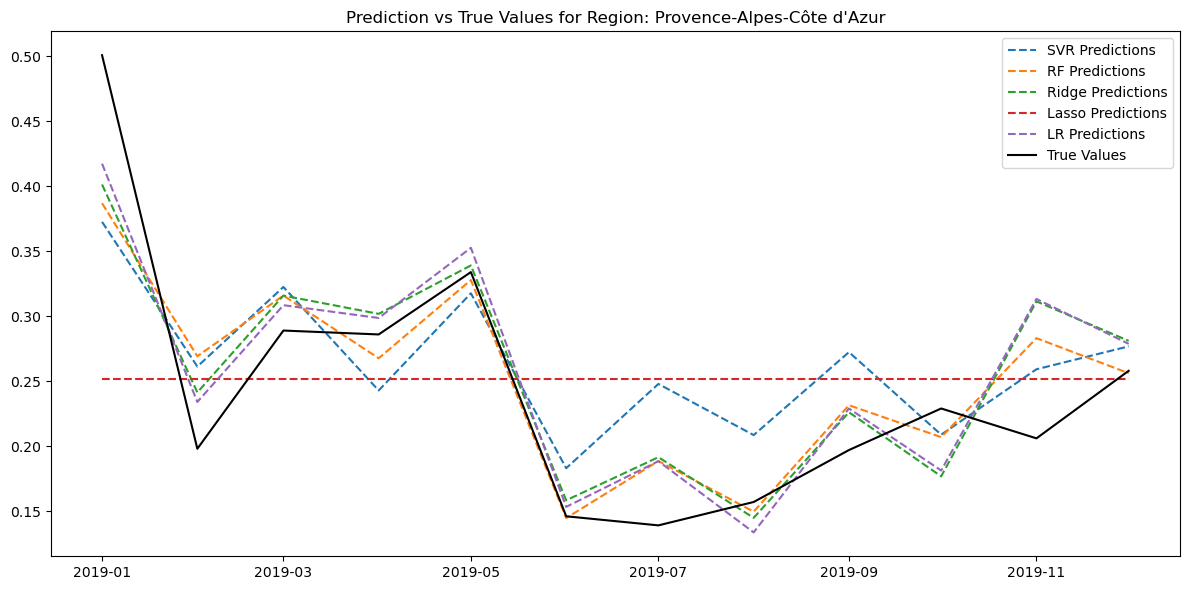

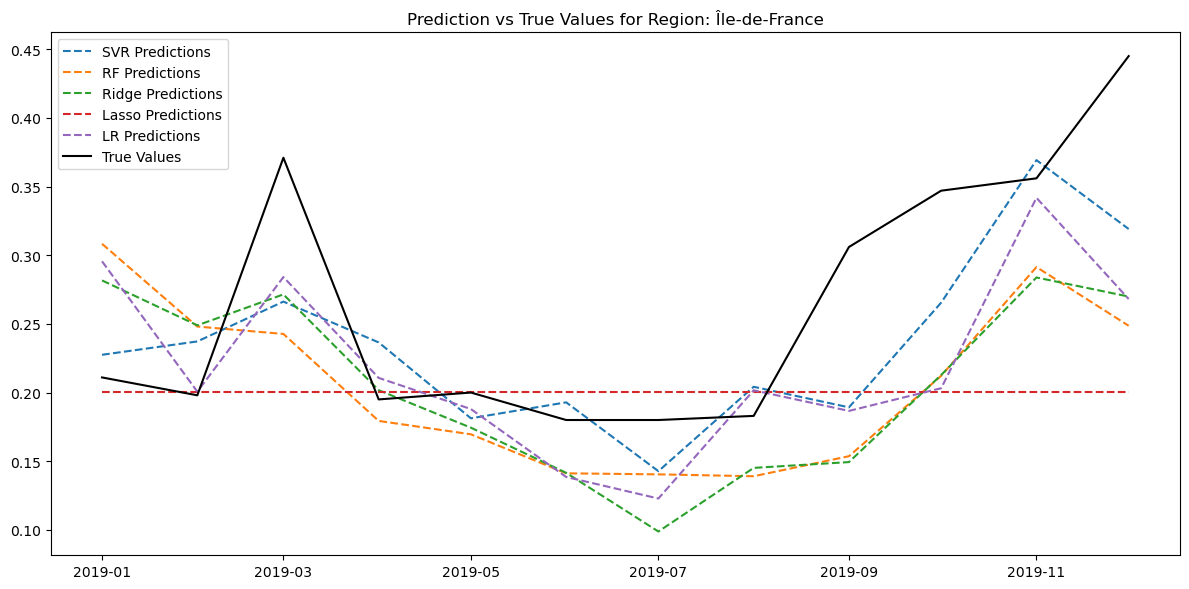

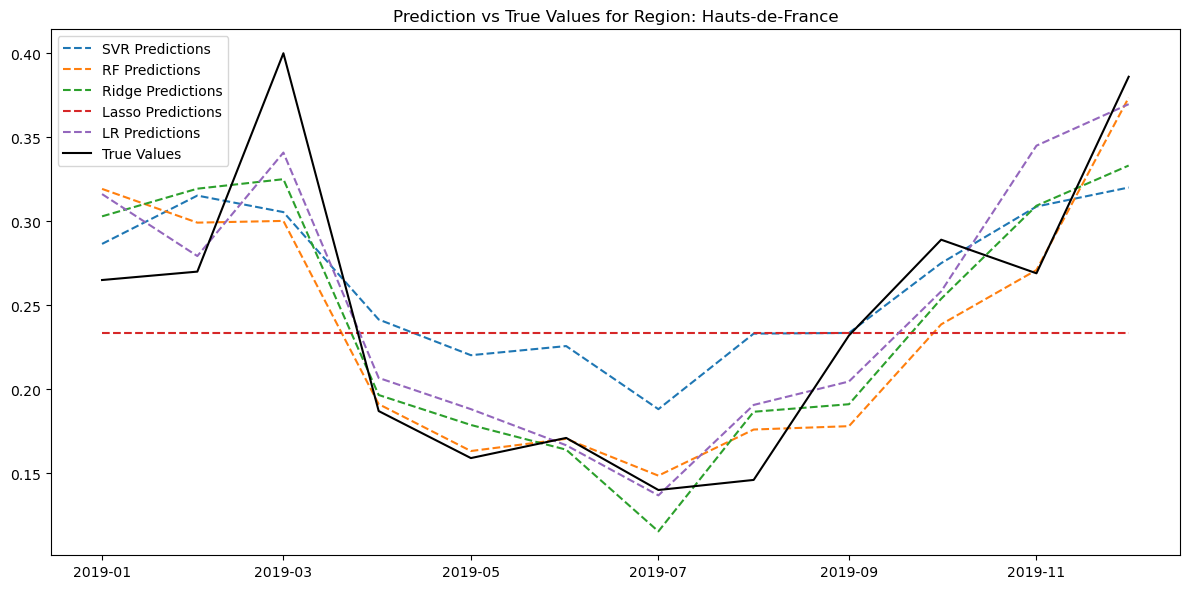

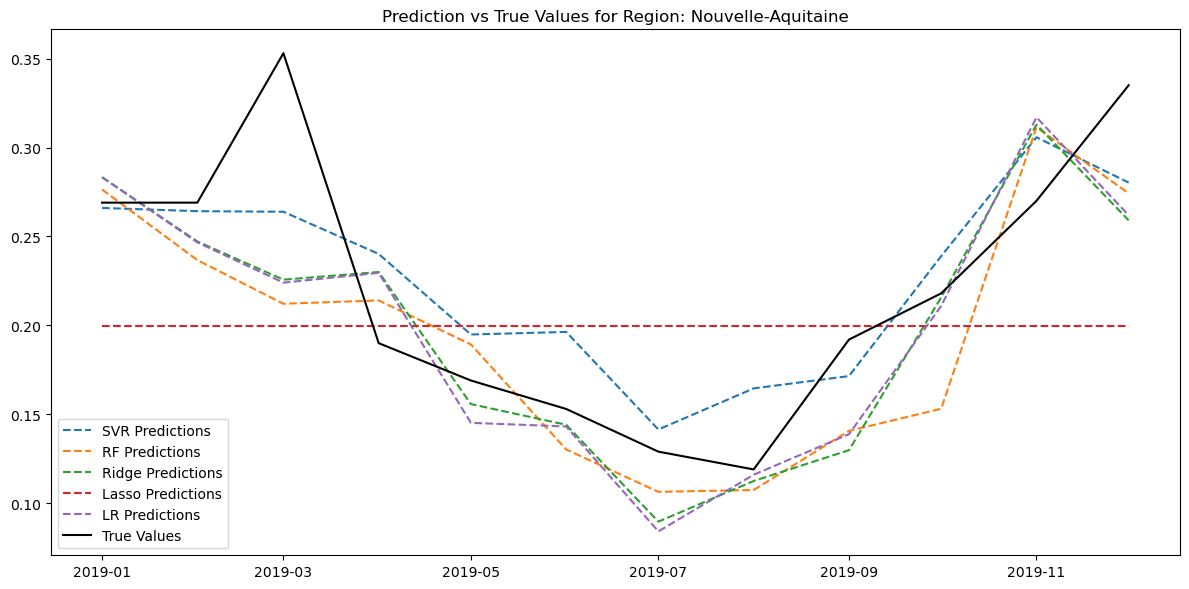

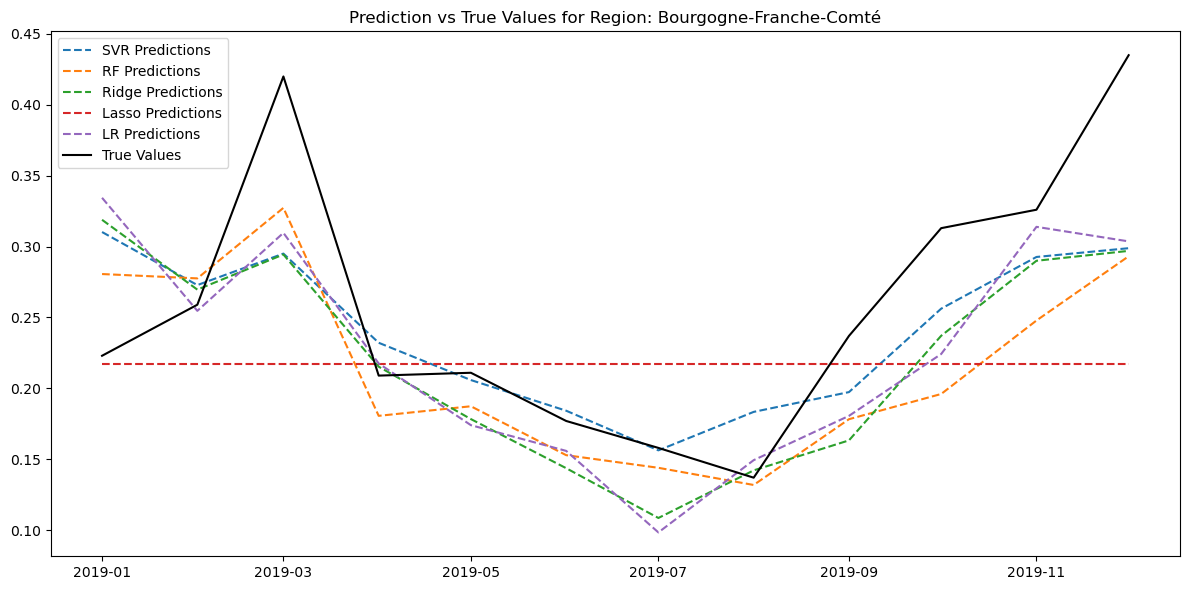

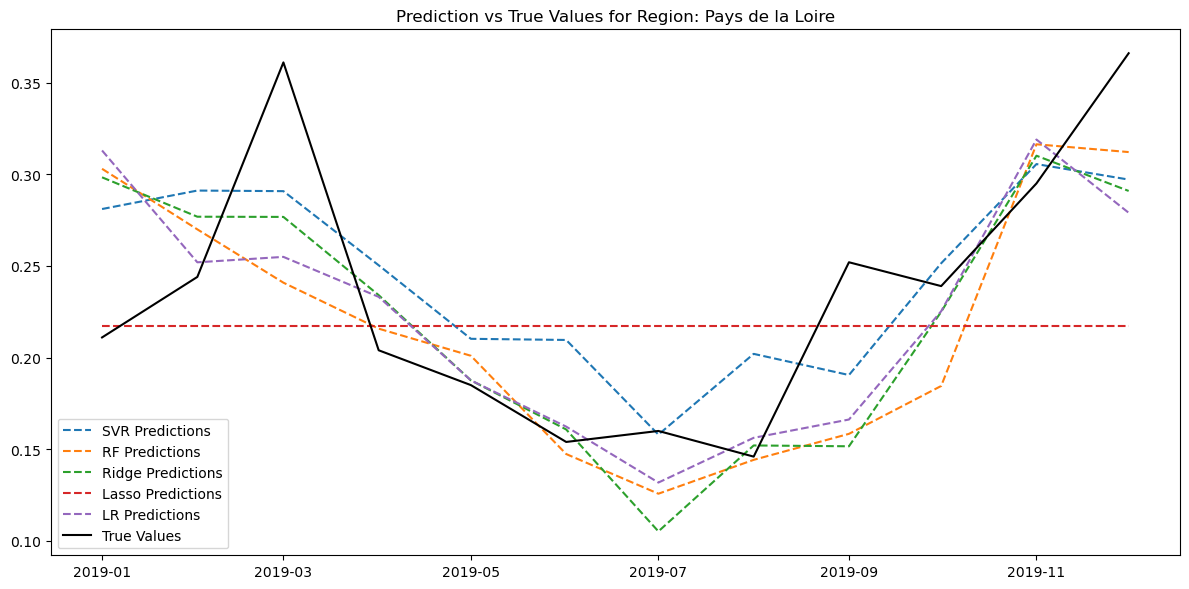

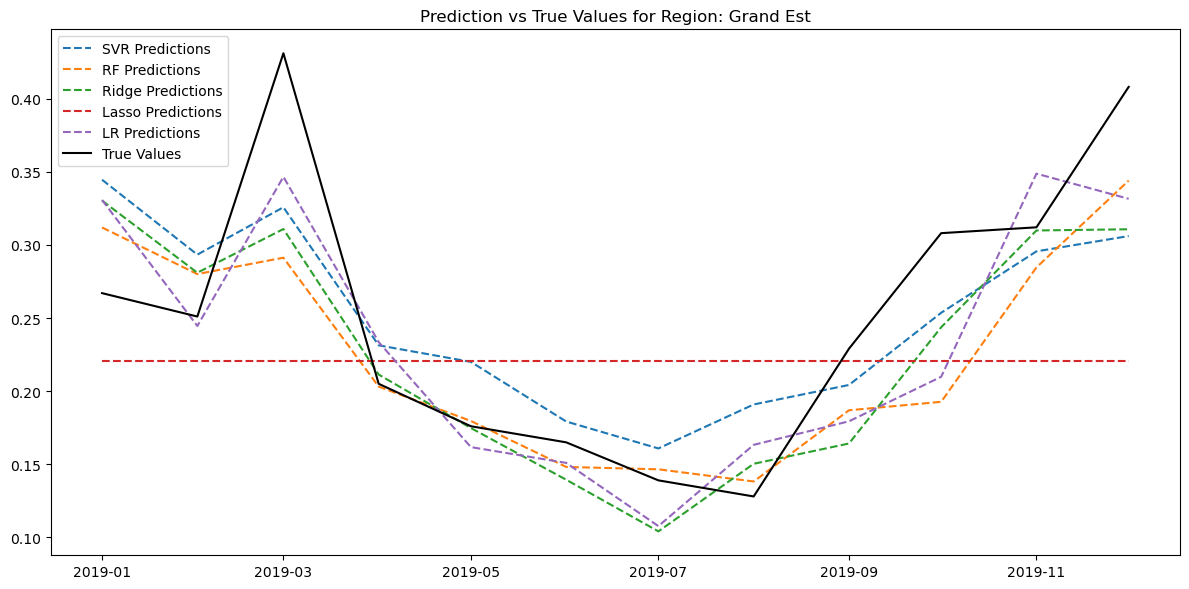

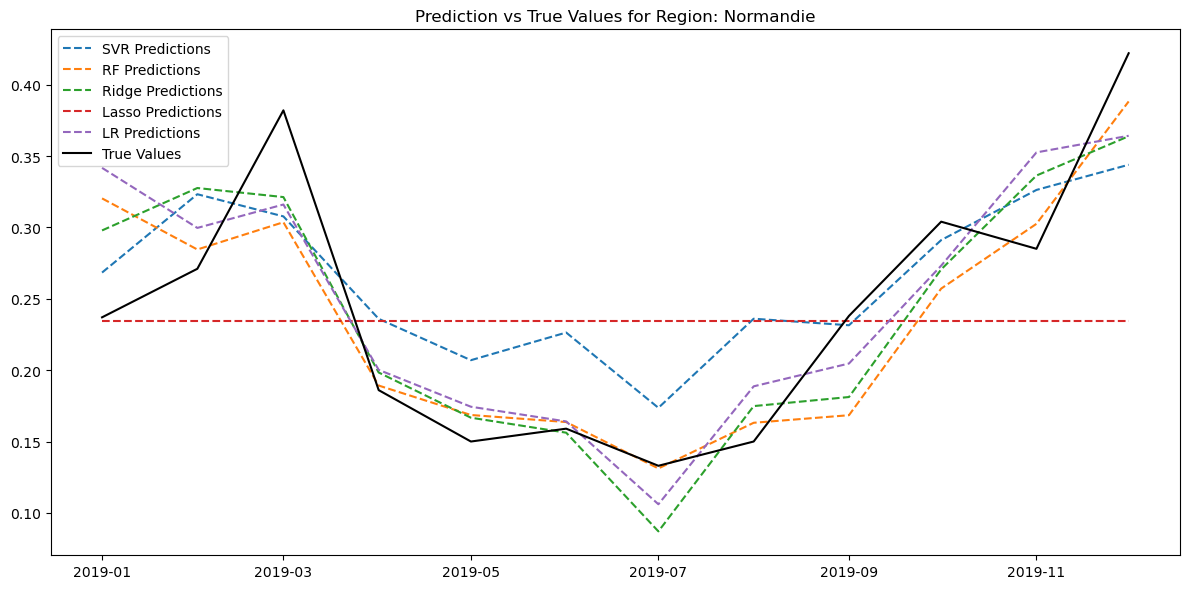

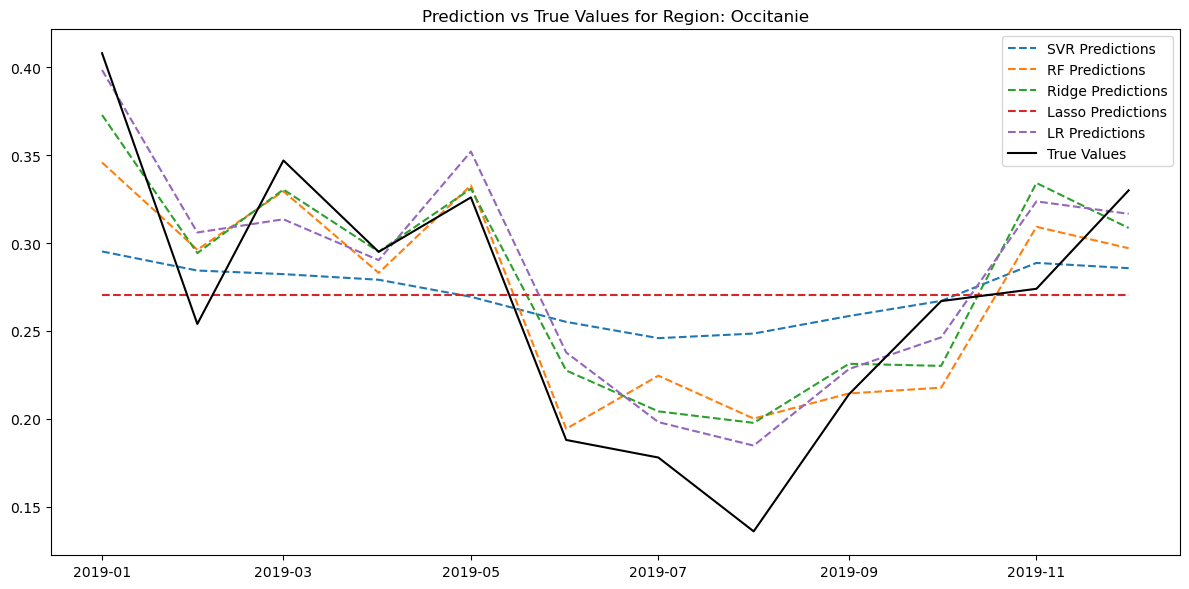

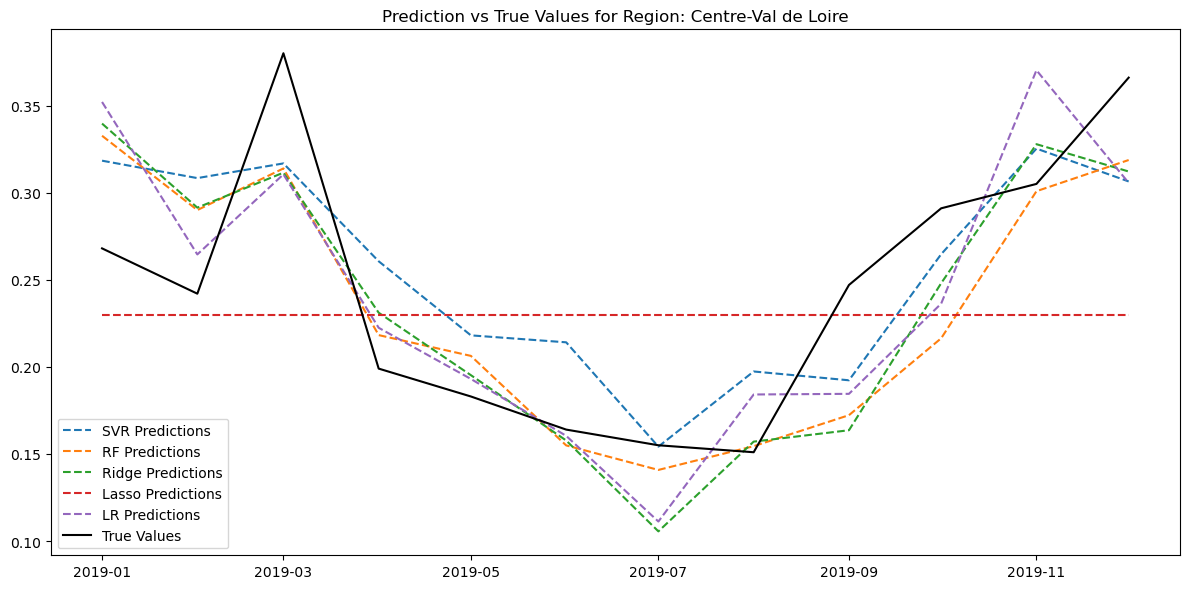

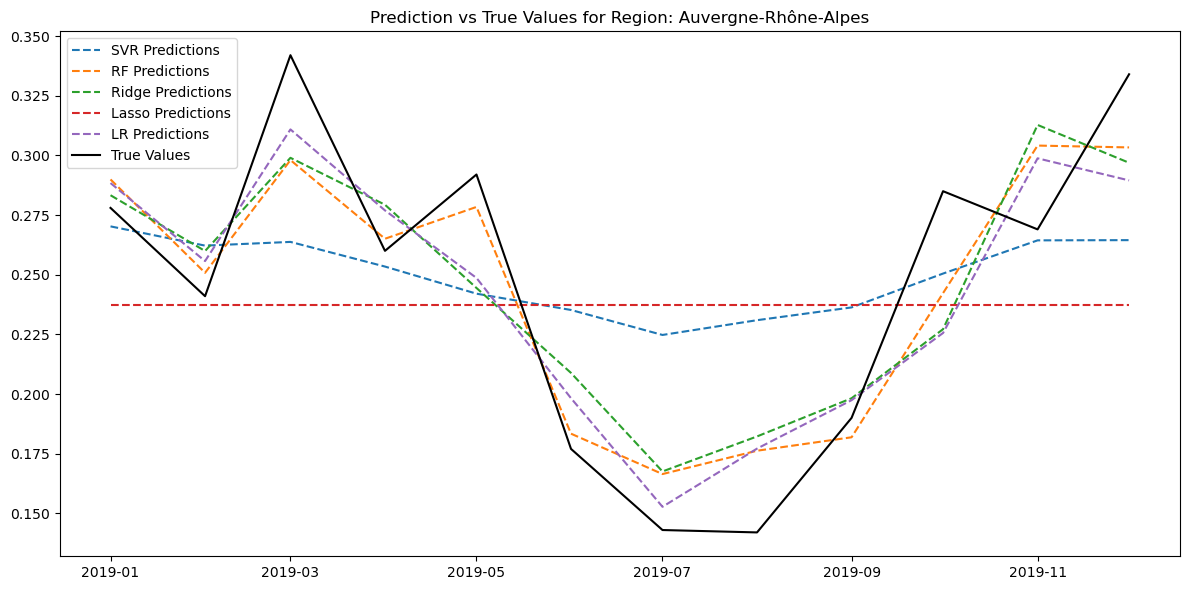

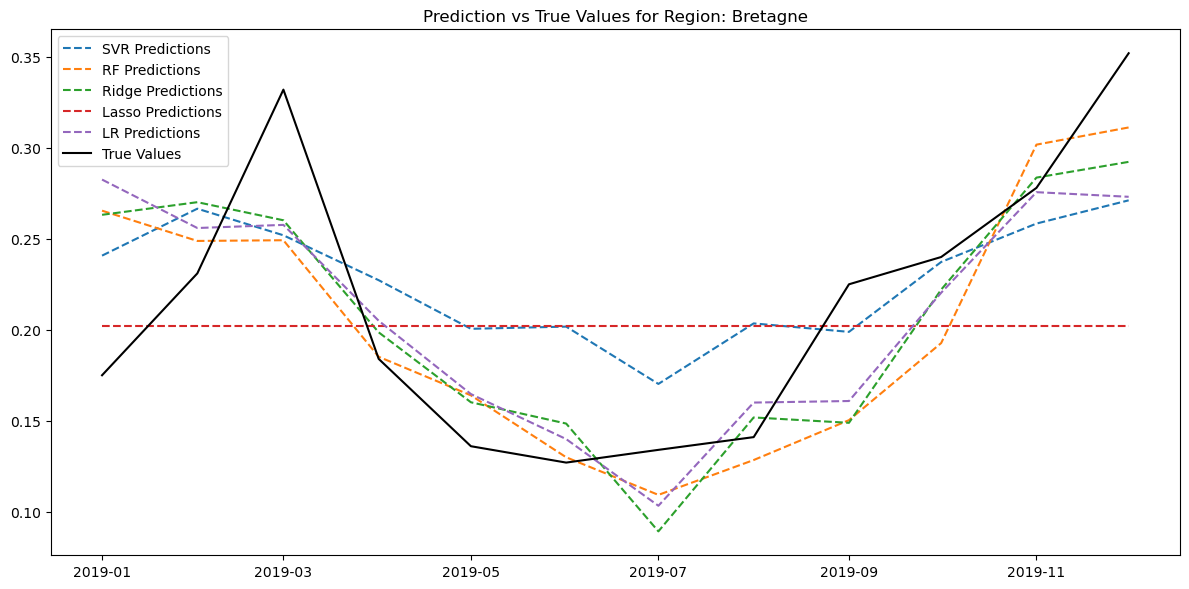

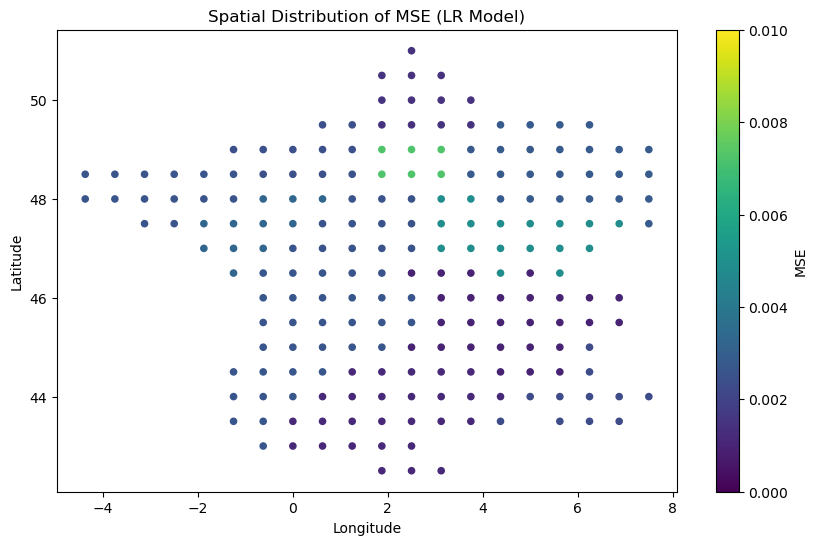

In [19]:
data_splits = preprocess_data(merged_dfs)
results, predictions = train_and_evaluate(data_splits)
display_results(results, predictions)

In [20]:
def compute_rf_feature_importance(data_splits):
    feature_importance_df = pd.DataFrame()

    for region, (X_train, X_test, y_train, y_test, scaler, feature_names) in data_splits.items():
        rf = RandomForestRegressor(random_state=42)
        rf.fit(X_train, y_train)

        importances = pd.Series(rf.feature_importances_, index=feature_names)
        top_features = importances.sort_values(ascending=False).head(3)

        feature_importance_df[region] = top_features.index

    feature_importance_df = feature_importance_df.T
    feature_importance_df.columns = ["Top 1", "Top 2", "Top 3"]

    return feature_importance_df

In [21]:
compute_rf_feature_importance(data_splits)

,Top 1,Top 2,Top 3
Provence-Alpes-Côte d'Azur,height_500,upper_meridional_wind,meridional_wind
Île-de-France,height_500,surface_density,surface_temperature
Hauts-de-France,surface_temperature,surface_downward_radiation,height_500
Nouvelle-Aquitaine,surface_temperature,height_500,surface_downward_radiation
Bourgogne-Franche-Comté,surface_density,surface_temperature,surface_specific_humidity
Pays de la Loire,surface_temperature,height_500,surface_downward_radiation
Grand Est,surface_density,surface_temperature,height_500
Normandie,surface_downward_radiation,surface_temperature,meridional_wind
Occitanie,height_500,surface_density,surface_temperature
Centre-Val de Loire,surface_temperature,surface_density,height_500


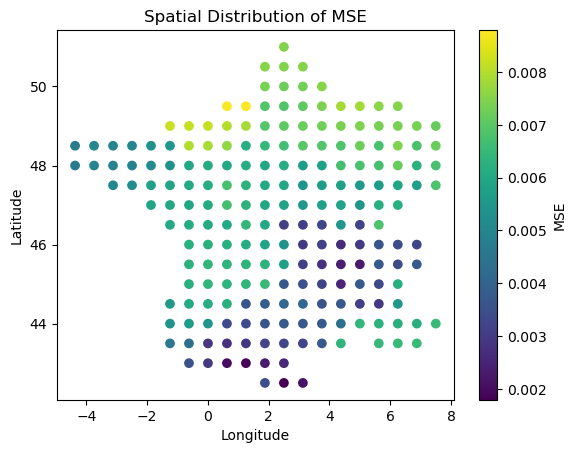

In [22]:
da_climate_monthly = da_climate.resample(time='MS').mean()

common_time = df_energy.index.intersection(da_climate_monthly['time'].values)
df_energy_aligned = df_energy.loc[common_time]
da_climate_aligned = da_climate_monthly.sel(time=common_time)

mse_map = []

adjusted_da_mask = da_mask - 2

for idx in range(len(adjusted_da_mask)):
    point_data = da_climate_aligned.isel(stacked_dim=idx).values
    region_index = int(adjusted_da_mask[idx].item())

    region_name = ds_mask['region'].values[region_index]
    region_fullname = region_name_mapping.get(region_name, region_name)
    energy_data = df_energy_aligned[region_fullname].values

    reg = LinearRegression()
    reg.fit(point_data.reshape(-1, 1), energy_data)
    predictions = reg.predict(point_data.reshape(-1, 1))
    mse = mean_squared_error(energy_data, predictions)
    mse_map.append(mse)

mse_map = np.array(mse_map)
plt.scatter(da_climate['lon'], da_climate['lat'], c=mse_map, cmap='viridis')
plt.title("Spatial Distribution of MSE")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='MSE')
plt.show()